## Clustering - DBSCAN (Datos de Geolocalización)

https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html

https://scikit-learn.org/stable/modules/clustering.html



### Tarea 1: Importar Librerías

In [1]:
pip install --upgrade --user numpy

In [2]:
conda install -c conda-forge hdbscan

Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\Mateo\anaconda3

  added / updated specs:
    - hdbscan


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    conda-4.10.3               |   py38haa244fe_0         3.1 MB  conda-forge
    hdbscan-0.8.27             |   py38h347fdf6_0         529 KB  conda-forge
    python_abi-3.8             |           2_cp38           4 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         3.6 MB

The following NEW packages will be INSTALLED:

  hdbscan            conda-forge/win-64::hdbscan-0.8.27-py38h347fdf6_0
  python_abi         conda-forge/win-64::python_abi-3.8-2_cp38

The following packages will be UPDATED:

  conda              pkgs/main::conda-4.10.1-py38haa95532_1 --> conda-forge::conda-4.10.3-py38haa244fe_0




python_



==> WARNING: A newer version of conda exists. <==
  current version: 4.10.1
  latest version: 4.10.3

Please update conda by running

    $ conda update -n base -c defaults conda




In [3]:
pip install hdbscan

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install folium

Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install re

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement re
ERROR: No matching distribution found for re


In [1]:
import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import pandas as pd
import numpy as np

from tqdm import tqdm

from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score #Permite evaluar el clustering
from sklearn.datasets import make_blobs
from sklearn.neighbors import KNeighborsClassifier

from ipywidgets import interactive
from collections import defaultdict

import hdbscan
import folium
import re

cols = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4',
        '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff',
        '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1',
        '#000075', '#808080']*10 #definición de colores


### Tarea 2: Limpieza del dataset

In [3]:
df = pd.read_csv('taxi_data.csv')

In [4]:
df.head()

,LON,LAT,NAME
0,28.17858,-25.73882,11th Street Taxi Rank
1,28.17660,-25.73795,81 Bazaar Street Taxi Rank
2,27.83239,-26.53722,Adams Road Taxi Rank
3,28.12514,-26.26666,Alberton City Mall Taxi Rank
4,28.10144,-26.10567,Alexandra Main Taxi Rank


In [5]:
#Verificar valores duplicados
df.duplicated(subset=['LON','LAT']).values.any()

True

In [6]:
#Verificar valores NAN
df.isna().values.any()

True

In [7]:
#Pre-processing (eliminar Nan y duplicated)
print(f'Antes de eliminr valores NaN y duplicados \t:\tdf.shape = {df.shape}')
df.dropna(inplace=True)
df.drop_duplicates(subset=['LON', 'LAT'], keep='first', inplace=True)
print(f'Luego de eliminar valores Nan y duplicados\t:\tdf.shape = {df.shape}')

Antes de eliminr valores NaN y duplicados 	:	df.shape = (838, 3)
Luego de eliminar valores Nan y duplicados	:	df.shape = (823, 3)


In [8]:
df.head()

,LON,LAT,NAME
0,28.17858,-25.73882,11th Street Taxi Rank
1,28.17660,-25.73795,81 Bazaar Street Taxi Rank
2,27.83239,-26.53722,Adams Road Taxi Rank
3,28.12514,-26.26666,Alberton City Mall Taxi Rank
4,28.10144,-26.10567,Alexandra Main Taxi Rank


In [9]:
#Datos en Numply array
X = np.array(df[['LON','LAT']], dtype='float64')

In [10]:
X

array([[ 28.17858, -25.73882],
       [ 28.1766 , -25.73795],
       [ 27.83239, -26.53722],
       ...,
       [ 27.83991, -26.24235],
       [ 27.86166, -26.23624],
       [ 28.39097, -26.30931]])

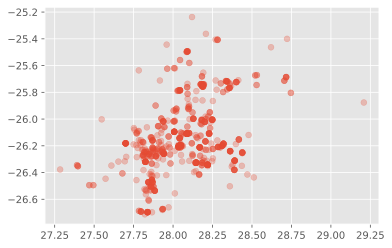

In [11]:
plt.scatter(X[:,0],X[:,1], alpha=0.3)

### Tarea 3: Visualización de datos geográficos

In [12]:
m = folium.Map(location=[df.LAT.mean(),df.LON.mean()], zoom_start=9, titles='Stamen Toner')

In [13]:
m #mapa sin datos

In [14]:
# Añadir datos al mapa
for _, row in df.iterrows():
    folium.CircleMarker(
        location = [row.LAT, row.LON],
        radius = 5,
        popup = re.sub(r'[^a-zA-Z]+', '', row.NAME),
        color = '#1787FE',
        fill = True,
        fill_colour = '#1787FE'
    
    ).add_to(m)

m

### Tarea 4: Clustering y métricas de rendimiento (silueta)

In [15]:
# El valor de la silueta [-1, 1], mejor valor tendiendo a 1

#Generción de datos randómicos (formando clusters)
X_blobs, _ = make_blobs(n_samples=1000, centers=10, n_features = 2,
                       cluster_std=0.5, random_state=4)


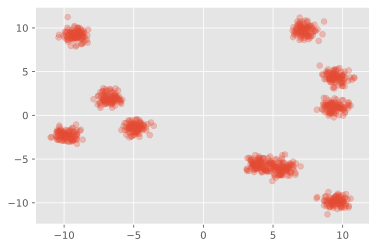

In [16]:
plt.scatter(X_blobs[:,0],X_blobs[:,1], alpha=0.3)

In [17]:
class_predictions = np.load('sample_clusters.npy') #Cada punto del grafico anterior
class_predictions

array([2, 2, 2, 2, 1, 0, 1, 0, 2, 1, 2, 1, 2, 0, 2, 1, 1, 1, 1, 1, 2, 0,
       2, 0, 2, 1, 2, 0, 0, 1, 2, 1, 0, 2, 0, 2, 2, 1, 1, 0, 0, 2, 2, 2,
       2, 1, 2, 1, 0, 2, 1, 2, 1, 1, 1, 2, 2, 2, 2, 2, 0, 0, 2, 2, 1, 0,
       2, 2, 0, 1, 2, 2, 0, 2, 2, 2, 0, 0, 1, 2, 1, 2, 0, 2, 2, 1, 2, 2,
       1, 2, 2, 0, 2, 1, 2, 2, 1, 0, 2, 2, 2, 0, 1, 0, 1, 2, 0, 0, 2, 2,
       0, 2, 0, 1, 2, 1, 1, 1, 1, 2, 1, 1, 0, 2, 0, 1, 1, 2, 1, 2, 0, 0,
       2, 0, 1, 1, 0, 2, 0, 0, 0, 0, 2, 1, 0, 2, 2, 2, 2, 0, 0, 2, 0, 2,
       1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 2, 2, 0, 2, 0, 2,
       2, 0, 1, 2, 1, 1, 2, 0, 1, 1, 2, 1, 2, 0, 2, 1, 0, 2, 2, 2, 0, 2,
       1, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 0, 1, 2, 2, 1, 1, 2, 2, 0, 2, 0,
       2, 1, 0, 2, 0, 2, 1, 0, 0, 0, 2, 2, 2, 1, 2, 1, 0, 0, 1, 0, 2, 1,
       1, 2, 0, 2, 0, 2, 2, 1, 0, 0, 0, 1, 1, 2, 1, 1, 0, 0, 1, 0, 2, 2,
       1, 0, 2, 1, 0, 0, 2, 1, 2, 1, 0, 0, 2, 2, 2, 0, 1, 0, 1, 0, 2, 1,
       0, 1, 1, 0, 1, 0, 1, 2, 2, 2, 0, 0, 1, 2, 0,

In [18]:
unique_clusters = np.unique(class_predictions)
unique_clusters

array([0, 1, 2])

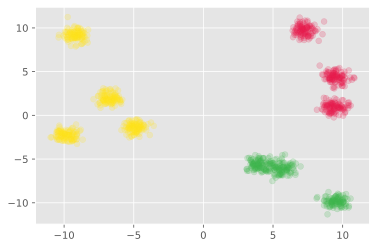

In [19]:
#Mapping de los datos anteriores (1000) a los clusters 0,1,2
for unique_cluster in unique_clusters:
    X = X_blobs[class_predictions==unique_cluster]
    plt.scatter(X[:,0], X[:,1], alpha=0.2, c = cols[unique_cluster])

In [20]:
silhouette_score(X_blobs, class_predictions)

0.6657220862867241

In [21]:
#Version mejorada
class_prediction2 = np.load('sample_clusters_improved.npy') #Cada punto del grafico anterior
class_prediction2

array([1, 6, 7, 7, 4, 3, 2, 3, 5, 4, 6, 2, 5, 0, 1, 9, 2, 2, 9, 9, 6, 0,
       7, 8, 1, 9, 5, 3, 8, 2, 1, 2, 0, 7, 8, 5, 7, 2, 9, 8, 8, 5, 7, 5,
       6, 2, 7, 9, 3, 6, 4, 7, 4, 2, 9, 6, 5, 1, 6, 7, 0, 0, 6, 7, 4, 3,
       7, 6, 8, 4, 5, 5, 3, 7, 6, 1, 3, 8, 9, 5, 9, 7, 8, 1, 1, 4, 5, 7,
       4, 7, 7, 8, 1, 2, 5, 7, 2, 3, 6, 6, 7, 8, 4, 8, 2, 6, 8, 8, 7, 1,
       0, 5, 0, 2, 7, 2, 2, 9, 2, 6, 2, 4, 3, 5, 8, 2, 2, 6, 4, 7, 8, 8,
       7, 0, 4, 4, 3, 6, 3, 3, 8, 8, 1, 9, 0, 6, 6, 7, 7, 3, 3, 1, 0, 5,
       2, 3, 0, 8, 0, 0, 2, 2, 0, 2, 3, 2, 2, 2, 2, 2, 6, 1, 3, 7, 8, 1,
       6, 8, 4, 1, 4, 2, 6, 3, 2, 4, 5, 2, 6, 0, 6, 9, 3, 6, 1, 5, 3, 5,
       4, 5, 7, 6, 4, 5, 5, 4, 5, 5, 7, 0, 2, 1, 7, 9, 2, 6, 6, 0, 1, 0,
       1, 4, 0, 7, 8, 7, 4, 0, 8, 0, 6, 7, 7, 2, 5, 4, 8, 0, 4, 3, 1, 4,
       4, 7, 8, 5, 3, 6, 1, 4, 8, 0, 0, 4, 9, 1, 4, 2, 8, 0, 9, 3, 6, 5,
       4, 0, 6, 2, 3, 0, 1, 2, 5, 9, 8, 0, 7, 1, 7, 0, 9, 0, 4, 0, 7, 9,
       3, 4, 9, 8, 2, 0, 9, 5, 5, 6, 3, 3, 2, 1, 3,

In [22]:
unique_clusters2 = np.unique(class_prediction2)
unique_clusters2

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

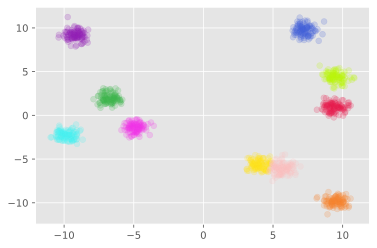

In [23]:
#Mapping de los datos anteriores (1000) a los clusters con modelo mejorado
for unique_cluster in unique_clusters2:
    X = X_blobs[class_prediction2==unique_cluster]
    plt.scatter(X[:,0], X[:,1], alpha=0.2, c = cols[unique_cluster])

In [24]:
silhouette_score(X_blobs, class_prediction2)

0.7473587799908298

**Ejercicio** Realizar el clustering utilizando K-Means

### Tarea 5: K-Means clustering

In [25]:
X_blobs, _ = make_blobs(n_samples=1000, centers=10, n_features = 2,
                       cluster_std=0.5, random_state=4)

In [26]:
np.unique(class_predictions)

array([0, 1, 2])

In [27]:
data = defaultdict(dict)
for x in range(1,21):
    model = KMeans(n_clusters=9, random_state=17, 
                   max_iter=x, n_init=1).fit(X_blobs)
    
    data[x]['class_predictions'] = model.predict(X_blobs)
    data[x]['centroids'] = model.cluster_centers_
    data[x]['unique_classes'] = np.unique(class_predictions)


In [28]:
def f(x):
    class_predictions = data[x]['class_predictions']
    centroids = data[x]['centroids']
    unique_classes = data[x]['unique_classes']
data= defaultdict(dict)

for x in range(1,21):
    model = KMeans(n_clusters=9, random_state=17, 
                   max_iter=x, n_init=1).fit(X_blobs)
    
    data[x]['class_predictions'] = model.predict(X_blobs)
    data[x]['centroids'] = model.cluster_centers_
    data[x]['unique_classes'] = np.unique(class_prediction)
    
    for unique_classes in unique_classes:
            plt.scatter(X_blobs[class_predictions==unique_class][:,0], 
                        X_blobs[class_predictions==unique_class][:,1], 
                        alpha=0.3, c=cols[unique_class])
    
            plt.scatter(centroids[:,0], centroids[:,1], s=200, c='#000000', marker='v')
            plt.ylim([-15,15]); plt.xlim([-15,15])
            plt.title('Iteración en los clusters K-Means')

interactive_plot = interactive(f, x=(1, 20))
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

NameError: name 'class_prediction' is not defined

In [29]:
silhouette_score(X_blobs, class_predictions)

0.6657220862867241

### Tarea 6: DBSCAN Clustering

In [30]:
model = DBSCAN(eps=0.01, min_samples=5).fit(X)
class_predictions = model.labels_

 

df['CLUSTERS_DBSCAN'] = class_predictions
m = create_map(df, 'CLUSTERS_DBSCAN')

ValueError: Length of values (100) does not match length of index (823)

In [ ]:

print(f'Number of clusters found: {len(np.unique(class_predictions))}')
print(f'Number of outliers found: {len(class_predictions[class_predictions==-1])}')

 

print(f'Silhouette ignoring outliers: {silhouette_score(X[class_predictions!=-1], class_predictions[class_predictions!=-1])}')

 

no_outliers = 0
no_outliers = np.array([(counter+2)*x if x==-1 else x for counter, x in enumerate(class_predictions)])
print(f'Silhouette outliers as singletons: {silhouette_score(X, no_outliers)}')



